In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,7)

In [ ]:
# Setting up the paths
historical_data_path = './data/AUDUSD/AUDUSD_2008-01-01_2019-10-16.csv'
model_path = '/content/drive/My Drive/Machine-Learning/Deep-Leraning_Learn/Time-Series-Analysis/audusd_trained_model.h5'
model_checkpoint_path = '/content/drive/My Drive/Machine-Learning/Deep-Leraning_Learn/Time-Series-Analysis/audusd_best-model_epoch.{epoch:02d}-val_loss{val_loss:.5f}.h5'
best_model_path = '/content/drive/My Drive/Machine-Learning/Deep-Leraning_Learn/Time-Series-Analysis/audusd_best-model_epoch.12-val_loss0.00044.h5'

## Loading and exploring AUD/USD data

In [4]:
data = pd.read_csv(historical_data_path, parse_dates=True, index_col='Date')
data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2019-10-16,0.6758,0.6754,0.6767,0.6723,0.07%
2019-10-15,0.6753,0.6774,0.6789,0.6741,-0.32%
2019-10-14,0.6775,0.6776,0.6802,0.6749,-0.21%
2019-10-11,0.6789,0.6762,0.6812,0.6752,0.40%
2019-10-10,0.6762,0.6725,0.6774,0.6707,0.55%


In [5]:
# reversing the order of dataframe's rows
data = data[::-1]
data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2008-01-01,0.8763,0.8743,0.8789,0.8735,0.05%
2008-01-02,0.8833,0.8760,0.8838,0.8756,0.80%
2008-01-03,0.8803,0.8836,0.8853,0.8785,-0.34%
2008-01-04,0.8711,0.8798,0.8838,0.8698,-1.05%
2008-01-07,0.8711,0.8714,0.8749,0.8681,0.00%


In [6]:
data.shape

(3077, 5)

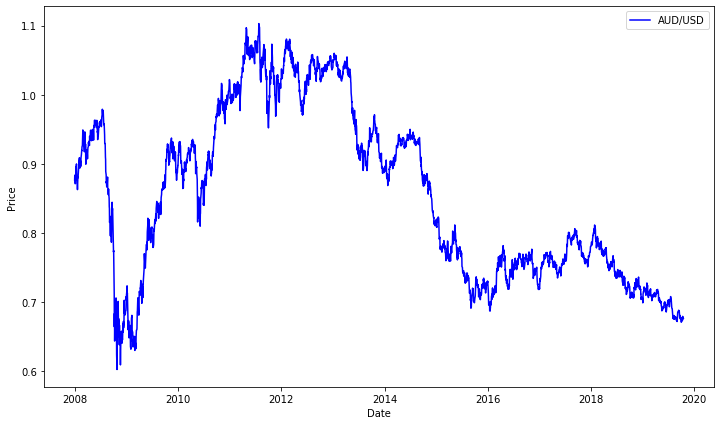

In [7]:
# plotting the AUD/USD Chart
plt.plot(data['Price'], label='AUD/USD', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Data Pre-Processing

In [8]:
# Storing 'Price' column into a numpy array
# Model will be trained only based on this feature (for now ...)
train_set = data.loc['2008-01-01':'2019-03-31', 'Price'].values
train_set = np.reshape(train_set, (train_set.shape[0], 1))
data_last_trained_row_index = train_set.shape[0] - 1
print(train_set.shape)
train_set

(2934, 1)


array([[0.8763],
       [0.8833],
       [0.8803],
       ...,
       [0.7085],
       [0.7076],
       [0.7097]])

In [9]:
test_set = data.loc['2019-04-01':'2019-04-30', 'Price'].values
test_set = np.reshape(test_set, (test_set.shape[0], 1))
print(test_set.shape)
test_set

(22, 1)


array([[0.7112],
       [0.7073],
       [0.7113],
       [0.7112],
       [0.7106],
       [0.7127],
       [0.7123],
       [0.7173],
       [0.7124],
       [0.7173],
       [0.7174],
       [0.7176],
       [0.7179],
       [0.7151],
       [0.7153],
       [0.7134],
       [0.7102],
       [0.7016],
       [0.7015],
       [0.704 ],
       [0.7057],
       [0.7049]])

In [10]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_set = sc.fit_transform(train_set)
test_set_scaled = sc.transform(test_set)
train_set

array([[0.54772364],
       [0.56170128],
       [0.55571086],
       ...,
       [0.21265974],
       [0.21086262],
       [0.21505591]])

In [11]:
train_set.shape

(2934, 1)

In [ ]:
# Creating a data structure with 80 timesteps and 1 output
timesteps = 80
X_train = []
y_train = []

for i in range(timesteps, train_set.shape[0]):
  X_train.append(train_set[i-timesteps:i, 0])
  y_train.append(train_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
# Reshaping X_train into a 3D array 
# (keras require 3D shaped array for LSTMs)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(2854, 80)
(2854, 80, 1)


## Building the RNN

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
#from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import GridSearchCV

In [ ]:
def build_lstm_regressor(output_activation, optimizer, dropout_rate=0.2):
  regressor = Sequential()
  regressor.add(LSTM(units=60, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
  regressor.add(Dropout(rate=dropout_rate))

  regressor.add(LSTM(units=60, activation='tanh', return_sequences=True))
  regressor.add(Dropout(rate=dropout_rate))

  regressor.add(LSTM(units=60, activation='tanh', return_sequences=True))
  regressor.add(Dropout(rate=dropout_rate))

  regressor.add(LSTM(units=60, activation='tanh', return_sequences=True))
  regressor.add(Dropout(rate=dropout_rate))

  regressor.add(LSTM(units=60, activation='tanh', return_sequences=True))
  regressor.add(Dropout(rate=dropout_rate))

  regressor.add(LSTM(units=60, activation='tanh', return_sequences=False))
  regressor.add(Dropout(rate=dropout_rate))

  regressor.add(Dense(units=1, activation=output_activation))

  regressor.compile(optimizer=optimizer, loss='mean_squared_error')

  return regressor

In [ ]:
# regressor = KerasRegressor(build_fn=build_lstm_regressor, epochs=110)
regressor = build_lstm_regressor(output_activation='sigmoid', optimizer='adam', dropout_rate=0.2)

### GridSearchCV Sction

In [ ]:
params = {
    'batch_size': [25, 32],
    'output_activation': ['sigmoid', None],
    'optimizer': ['adam', 'rmsprop']
}

In [ ]:
gs = GridSearchCV(estimator=regressor, param_grid=params, scoring='neg_mean_squared_error', cv=10)

In [ ]:
start_time = time.time()
gs_fit = gs.fit(X_train, y_train)
end_time = time.time()
gs_time = (start_time - end_time)
best_parameters = gs.best_params_
best_accuracy = gs.best_score_
print(gs_time)

### Model fitting section

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Building 'EarlyStopping' callback to stop training when model is not improving
# Building 'ModelCheckpoint' callback to save the best model during training time
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, min_delta=0.00003)
model_checkpoint = ModelCheckpoint(filepath=model_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callbacks = [early_stop, model_checkpoint]

In [ ]:
"""
print(X_train.shape)
print(y_train.shape)
print(X_train[0])
print(X_train[1])
print(y_train[0])
"""

In [ ]:
# Fiiting the model and recording the time
start_time = time.time()
regressor.fit(x=X_train, y=y_train, validation_split=0.2, epochs=250, batch_size=25, callbacks=callbacks)
end_time = time.time()
fit_time = (start_time - end_time)
print(fit_time)

In [ ]:
# Save the trained model
regressor.save(model_path)

In [ ]:
# Load the trained model
from keras.models import load_model
regressor = load_model(model_path)

In [22]:
type(regressor)

keras.engine.sequential.Sequential

## Making the predictions

In [23]:
uband = data_last_trained_row_index + 1
lband = uband - timesteps

data.iloc[lband:uband, :]

,Price,Open,High,Low,Change %
Date,,,,,
2018-12-10,0.7190,0.7193,0.7228,0.7166,-0.14%
2018-12-11,0.7207,0.7189,0.7225,0.7183,0.24%
2018-12-12,0.7221,0.7208,0.7240,0.7198,0.19%
2018-12-13,0.7227,0.7220,0.7248,0.7210,0.08%
2018-12-14,0.7177,0.7227,0.7228,0.7149,-0.69%
...,...,...,...,...,...
2019-03-25,0.7113,0.7077,0.7117,0.7065,0.41%
2019-03-26,0.7135,0.7110,0.7147,0.7105,0.31%
2019-03-27,0.7085,0.7133,0.7143,0.7066,-0.70%


In [27]:
# building inputs
inputs = data.iloc[lband:uband, 0].values
inputs

array([0.719 , 0.7207, 0.7221, 0.7227, 0.7177, 0.7175, 0.7183, 0.7108,
       0.7109, 0.7034, 0.7062, 0.7037, 0.7067, 0.7036, 0.7044, 0.7052,
       0.7053, 0.6985, 0.7006, 0.7113, 0.7148, 0.7141, 0.7171, 0.7186,
       0.7216, 0.7196, 0.7201, 0.7168, 0.7194, 0.7168, 0.7158, 0.7123,
       0.7142, 0.7095, 0.7183, 0.7166, 0.7156, 0.7247, 0.7273, 0.7251,
       0.7226, 0.7235, 0.7104, 0.7101, 0.709 , 0.7062, 0.7095, 0.7089,
       0.7106, 0.714 , 0.7131, 0.7166, 0.7164, 0.7095, 0.7127, 0.7167,
       0.7188, 0.7139, 0.7095, 0.7083, 0.7093, 0.7084, 0.7033, 0.7016,
       0.7047, 0.707 , 0.7081, 0.7094, 0.7065, 0.7089, 0.7105, 0.7088,
       0.7116, 0.7112, 0.7084, 0.7113, 0.7135, 0.7085, 0.7076, 0.7097])

In [28]:
# reshaping and scaling the inputs
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
print(inputs.shape)

(80, 1)


In [31]:
inputs = np.reshape(inputs, (1, inputs.shape[0], 1))
print(inputs.shape)

(1, 80, 1)


In [32]:
predicted_price = regressor.predict(inputs)
predicted_price = sc.inverse_transform(predicted_price)
print(data.iloc[uband: uband+1])
print(predicted_price[0,0])

             Price    Open    High     Low Change %
Date                                               
2019-04-01  0.7112  0.7113  0.7133  0.7101    0.21%
0.717494


In [33]:
data_last_trained_row_index

2933

In [ ]:
predicted_prices = []

for i in range(0, 22):
  lower_band = (data_last_trained_row_index + 1 - timesteps + i)
  upper_band = (data_last_trained_row_index + 1 + i) 
  inputs = data.iloc[lower_band:upper_band, 0].values
  inputs = inputs.reshape(-1, 1)
  inputs = sc.transform(inputs)  
  inputs = np.reshape(inputs, (1, inputs.shape[0], 1))  
  pred_price = regressor.predict(inputs)  
  predicted_prices.append(sc.inverse_transform(pred_price)[0, 0])
  

  """
  X_train_temp = data.iloc[lower_band+1:upper_band+1, 0].values
  X_train_temp = X_train_temp.reshape(-1, 1)
  X_train_temp = sc.transform(X_train_temp)
  X_train_temp = np.array(X_train_temp)
  X_train_temp = np.reshape(X_train_temp, (1, X_train_temp.shape[0], X_train_temp.shape[1]))
  # print(X_train_temp.shape)

  y_train_temp = data.iloc[upper_band+1, 0]
  y_train_temp = y_train_temp.reshape(-1, 1)
  y_train_temp = sc.transform(y_train_temp)
  y_train_temp = np.array(y_train_temp)
  # print(y_train_temp.shape)
  
  regressor.fit(x=X_train_temp, y=y_train_temp, epochs=10)
  """

In [35]:
print(len(predicted_prices))
predicted_prices

22


[0.717494,
 0.7191657,
 0.7173337,
 0.7189231,
 0.72001004,
 0.72000897,
 0.72133905,
 0.7217743,
 0.7252772,
 0.72364855,
 0.72569895,
 0.7269896,
 0.727447,
 0.72767967,
 0.72572964,
 0.72475344,
 0.7231142,
 0.72006035,
 0.7126314,
 0.70870036,
 0.70960677,
 0.711671]

In [38]:
y_true = data.loc['2019-04-01':'2019-04-30', 'Price'].values
print(len(y_true))
y_true

22


array([0.7112, 0.7073, 0.7113, 0.7112, 0.7106, 0.7127, 0.7123, 0.7173,
       0.7124, 0.7173, 0.7174, 0.7176, 0.7179, 0.7151, 0.7153, 0.7134,
       0.7102, 0.7016, 0.7015, 0.704 , 0.7057, 0.7049])

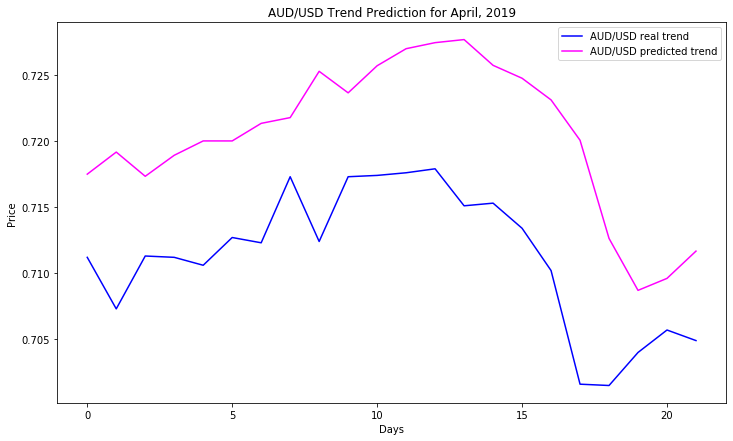

In [49]:
plt.plot(y_true, color='blue', label='AUD/USD real trend')
plt.plot(predicted_prices, color='magenta', label='AUD/USD predicted trend')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('AUD/USD Trend Prediction for April, 2019')
plt.legend()
plt.show()

#fname = '/content/drive/My Drive/Machine-Learning/Deep-Leraning_Learn/Time-Series-Analysis/AUDUSD-Trend-Prediction-April-2019.png'
#plt.savefig(fname=fname)

In [ ]:
def predict_audusd_trend(start_date, end_date):
  y_true = data.loc[start_date:end_date, 'Price'].values
  n_days = len(y_true)
  last_row_index = len(data.loc['2008-01-01': start_date])

  # Pridicting
  predicted_prices = []
  for i in range(0, n_days):
    upper_band = (last_row_index - 1 + i) 
    lower_band = upper_band - timesteps
    
    inputs = data.iloc[lower_band:upper_band, 0].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)  
    inputs = np.reshape(inputs, (1, inputs.shape[0], 1))  
    pred_price = regressor.predict(inputs)  
    predicted_prices.append(sc.inverse_transform(pred_price)[0, 0])

  # Plotting/Saving the figure
  plt.plot(y_true, color='blue', label='AUD/USD real trend')
  plt.plot(predicted_prices, color='magenta', label='AUD/USD predicted trend')
  plt.xlabel('Days')
  plt.ylabel('Price')
  plt.title(f'AUD/USD Trend Prediction - {start_date} to {end_date}')
  plt.legend()
  fname = f'/content/drive/My Drive/Machine-Learning/Deep-Leraning_Learn/Time-Series-Analysis/AUDUSD-Trend-Prediction-{start_date}-to-{end_date}.png'
  plt.savefig(fname=fname)
  #plt.show()

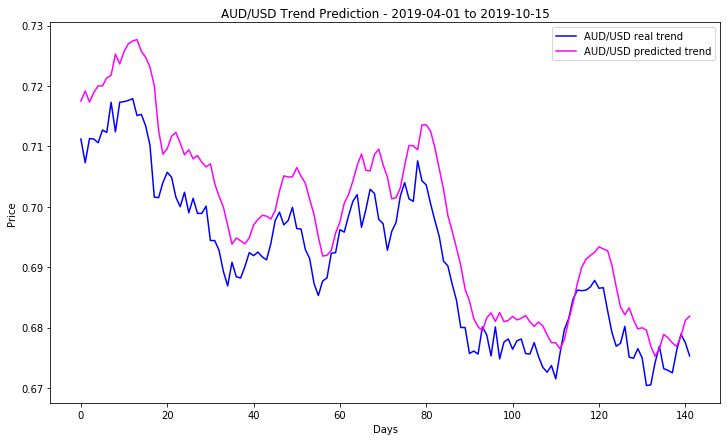

In [64]:
predict_audusd_trend(start_date='2019-04-01', end_date='2019-10-15')

In [56]:
len(data.loc['2008-01-01': '2019-04-01'])

2935

In [60]:
data.iloc[2935-2]

Price       0.7097
Open        0.7078
High        0.7107
Low         0.7073
Change %     0.30%
Name: 2019-03-29 00:00:00, dtype: object

In [53]:
data.loc['2019-03-29']

Price       0.7097
Open        0.7078
High        0.7107
Low         0.7073
Change %     0.30%
Name: 2019-03-29 00:00:00, dtype: object